In [1]:
# imoporting libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier

from scipy.stats import randint, uniform

In [2]:
# Load the data
raw_data = pd.read_csv('/home/nahomnadew/Desktop/10x/auto_insurance/auto/data/car_insurance_claim.csv')

In [3]:
# Display all columns
pd.set_option('display.max_columns', None)
raw_data.head()

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,M,Bachelors,Manager,26,Private,"$21,970",1,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


In [4]:
data_df = raw_data.copy()


In [5]:
#rename the columns to be more descriptive
col_names = {
    'KIDSDRIV': 'num_young_drivers',
    'BIRTH': 'date_of_birth',
    'AGE': 'age',
    'HOMEKIDS': 'num_of_children',
    'YOJ': 'years_job_held_for',
    'INCOME': 'income',
    'PARENT1': 'single_parent',
    'HOME_VAL': 'value_of_home',
    'MSTATUS': 'married',
    'GENDER': 'gender',
    'EDUCATION': 'highest_education',
    'OCCUPATION': 'occupation',
    'TRAVTIME': 'commute_dist',
    'CAR_USE': 'type_of_use',
    'BLUEBOOK': 'vehicle_value',
    'TIF': 'policy_tenure',
    'CAR_TYPE': 'vehicle_type',
    'RED_CAR': 'red_vehicle',
    'OLDCLAIM': '5_year_total_claims_value',
    'CLM_FREQ': '5_year_num_of_claims',
    'REVOKED': 'licence_revoked',
    'MVR_PTS': 'license_points',
    'CLM_AMT': 'new_claim_value',
    'CAR_AGE': 'vehicle_age',
    'CLAIM_FLAG': 'is_claim',
    'URBANICITY': 'address_type'
}

# Update column names
data_df.rename(columns=col_names, inplace=True)

In [6]:
data_df.info()
#we see the column manes have changed to be more descriptive.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         10302 non-null  int64  
 1   num_young_drivers          10302 non-null  int64  
 2   date_of_birth              10302 non-null  object 
 3   age                        10295 non-null  float64
 4   num_of_children            10302 non-null  int64  
 5   years_job_held_for         9754 non-null   float64
 6   income                     9732 non-null   object 
 7   single_parent              10302 non-null  object 
 8   value_of_home              9727 non-null   object 
 9   married                    10302 non-null  object 
 10  gender                     10302 non-null  object 
 11  highest_education          10302 non-null  object 
 12  occupation                 9637 non-null   object 
 13  commute_dist               10302 non-null  int

In [7]:
# che the number of duplicates in the data
data_df.duplicated().sum()

1

we can see we have one duplicate row. our next move should be remove the duplicate row.

In [8]:
data_df.drop_duplicates(inplace=True)
if data_df.duplicated().sum()==0:
    print('No duplicates found, duplicates have been removed')

No duplicates found, duplicates have been removed


## removing unnecessary things from strings

In [9]:
#replace '$' sign in the currency columns
col_currency = ['income', 'value_of_home', 'vehicle_value', '5_year_total_claims_value', 'new_claim_value']
def remove_currency_sign(data, cols: list):
    for col in cols:
        data[col] = data[col].replace('[//$,]', '', regex=True).astype('Int64')
    return data
data_df = remove_currency_sign(data_df, col_currency)
print(data_df[col_currency].head())
print("successfully removed currency sign")


   income  value_of_home  vehicle_value  5_year_total_claims_value  \
0   67349              0          14230                       4461   
1   91449         257252          14940                          0   
2   52881              0          21970                          0   
3   16039         124191           4010                      38690   
4    <NA>         306251          15440                          0   

   new_claim_value  
0                0  
1                0  
2                0  
3                0  
4                0  
successfully removed currency sign


In [10]:
z_prefix_cols = ['married', 'gender', 'highest_education', 'occupation', 'vehicle_type', 'address_type']
def remove_z_prefix(data, cols: list):
    for col in cols:
        data[col] = data[col].replace('z_', '', regex=True)
    return data
data_df = remove_z_prefix(data_df, z_prefix_cols)
data_df.head()
print(data_df[z_prefix_cols].head())
print("succssfully removed the z_ prefix from the columns")

  married gender highest_education    occupation vehicle_type  \
0      No      M               PhD  Professional      Minivan   
1      No      M       High School   Blue Collar      Minivan   
2      No      M         Bachelors       Manager          Van   
3     Yes      F       High School      Clerical          SUV   
4     Yes      M      <High School   Blue Collar      Minivan   

          address_type  
0  Highly Urban/ Urban  
1  Highly Urban/ Urban  
2  Highly Urban/ Urban  
3  Highly Urban/ Urban  
4  Highly Urban/ Urban  
succssfully removed the z_ prefix from the columns


now, we can drop unnecessary columns from the data set. for now, we will be removing date of birth and ID features

In [11]:
def remove_unnecessary_columns(data):
    if 'date_of_birth'  in data.columns:
        data.drop(columns=['date_of_birth'],axis=1, inplace=True)
    if 'ID' in data.columns:
        data.drop(columns=['ID'], axis= 1, inplace=True)
    return data
data_df = remove_unnecessary_columns(data_df)
data_df.head()


,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,0,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,52881,No,0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


## creating train test split
we will be using the concept of stratifying in order to make a fair destribution of data

In [12]:
#lets check if there are new claims with a claim value greater than 0 and no claim
check = (data_df['new_claim_value']>0 )& (data_df['is_claim']==0)
print(data_df[check])
print("-> here are no claims with a claim value greater than 0 and no claim")

Empty DataFrame
Columns: [num_young_drivers, age, num_of_children, years_job_held_for, income, single_parent, value_of_home, married, gender, highest_education, occupation, commute_dist, type_of_use, vehicle_value, policy_tenure, vehicle_type, red_vehicle, 5_year_total_claims_value, 5_year_num_of_claims, licence_revoked, license_points, new_claim_value, vehicle_age, is_claim, address_type]
Index: []
-> here are no claims with a claim value greater than 0 and no claim


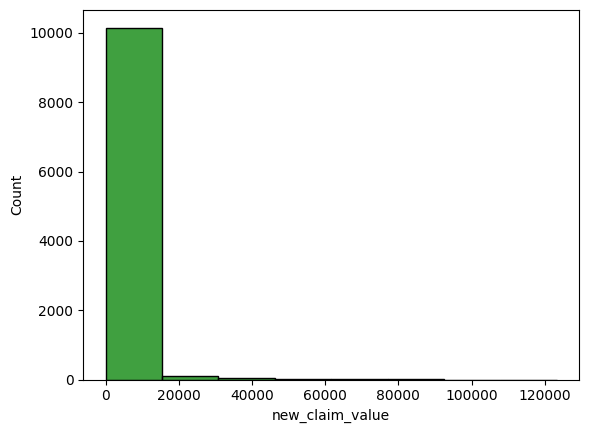

In [13]:
sns.histplot(data_df['new_claim_value'], bins=8, color='green')
plt.show()


the graph is skewed to the right. doing linear stratifying might harm the fair representation of daata in representing the data when splitting into test and train data

In [14]:
# Define bins
bins = [0.0, 5000, 10_000, 15_000, 20_000, 25_000, 30_000, 35_000, 40_000, 45_000, 50_000, np.inf]
# Define bin labels
labels = np.arange(1, 12)

# Apply the bins using cut
data_df['claim_value_cat'] = pd.cut(data_df['new_claim_value'], bins = bins, labels= labels, include_lowest=True)

<Axes: ylabel='claim_value_cat'>

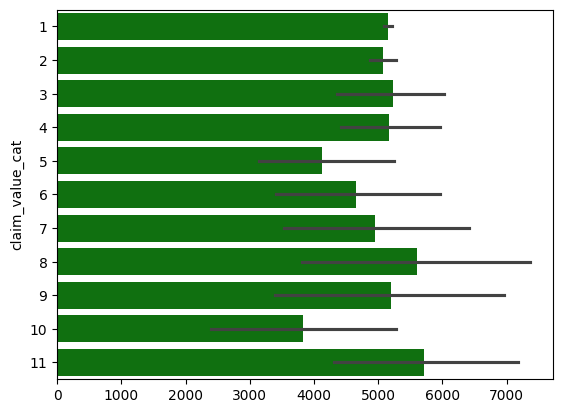

In [15]:
sns.barplot(data_df['claim_value_cat'], color='green')

In [16]:

x = data_df.copy()
y = data_df['is_claim']

#drop the target column from the features
x.drop(columns=['is_claim', 'new_claim_value'], inplace=True)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=x['claim_value_cat'])



In [17]:
#test the fairness of the split
train_ratio = round(y_train.sum()/len(y_train), 2)
test_ratio = round(y_test.sum()/len(y_test), 2)
print(f'Train ratio: {train_ratio}')
print(f'Test ratio: {test_ratio}')

#compare the ratios
if (train_ratio + 0.05*train_ratio) > test_ratio > (train_ratio - 0.05*train_ratio):
    print('The split is fair')
else:
    print('The split is not fair')

Train ratio: 0.26
Test ratio: 0.27
The split is fair


now, taken we have made the split, we can remove the stratification category from x_train and x_test data sets

In [28]:
for d_set in (x_train, x_test):
    if 'claim_value_cat' in d_set.columns:
        d_set.drop(columns=['claim_value_cat'], inplace=True)

### Explaratory data analysis

In [ ]:
e_data = x_train.copy()
e_data['is_claim'] = y_train
e_data.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,address_type,is_claim
8452,0,57.0,0,NaN,33707,No,0,No,F,<High School,Blue Collar,40,Private,7200,10,SUV,no,0,0,No,1,1.0,Highly Rural/ Rural,0
7822,2,41.0,3,14.0,17321,No,109835,Yes,F,<High School,Blue Collar,24,Private,6530,4,Sports Car,no,0,0,No,3,1.0,Highly Urban/ Urban,0
1312,0,29.0,2,12.0,54310,Yes,174139,No,M,<High School,Clerical,39,Private,1500,4,Minivan,no,5419,1,No,5,6.0,Highly Urban/ Urban,1
921,0,46.0,1,13.0,62886,Yes,202178,No,F,Bachelors,Professional,18,Private,22260,1,Minivan,no,5290,1,No,6,6.0,Highly Urban/ Urban,0
8708,0,39.0,0,8.0,115182,No,312887,Yes,M,High School,Professional,25,Commercial,5400,1,Pickup,no,0,0,No,1,5.0,Highly Urban/ Urban,0


For the purpose of the exploration, we will first update 'Yes/No' features to binary so we can see how these correlate too. We'll also update gender to use binary values. 1 = male, 0 = female

In [31]:
# Create a new copy of X_train for the analysis
eda_test_data = x_train.copy()
eda_test_data['is_claim'] = y_train

In [32]:
# Define binary columns
binary_cols = ['single_parent', 'married', 'gender', 'red_vehicle', 'licence_revoked']

# Define map values
mapping = {'Yes': 1,
           'No': 0,
           'yes': 1,
           'no': 0,
           'M': 1,
           'F': 0,
           }

# Define function to binarise features
def binarise_values(data, cols, map):
    for col in cols:
        data[col] = data[col].map(map)
    return data

# Call function
eda_test_data = binarise_values(eda_test_data, binary_cols, mapping)
eda_test_data.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,vehicle_age,address_type,is_claim
8452,0,57.0,0,NaN,33707,0,0,0,0,<High School,Blue Collar,40,Private,7200,10,SUV,0,0,0,0,1,1.0,Highly Rural/ Rural,0
7822,2,41.0,3,14.0,17321,0,109835,1,0,<High School,Blue Collar,24,Private,6530,4,Sports Car,0,0,0,0,3,1.0,Highly Urban/ Urban,0
1312,0,29.0,2,12.0,54310,1,174139,0,1,<High School,Clerical,39,Private,1500,4,Minivan,0,5419,1,0,5,6.0,Highly Urban/ Urban,1
921,0,46.0,1,13.0,62886,1,202178,0,0,Bachelors,Professional,18,Private,22260,1,Minivan,0,5290,1,0,6,6.0,Highly Urban/ Urban,0
8708,0,39.0,0,8.0,115182,0,312887,1,1,High School,Professional,25,Commercial,5400,1,Pickup,0,0,0,0,1,5.0,Highly Urban/ Urban,0


In [37]:
eda_test_data.corr(numeric_only=True).sort_values(by='is_claim', ascending=False)['is_claim']

is_claim                     1.000000
5_year_num_of_claims         0.224952
license_points               0.218605
licence_revoked              0.158972
single_parent                0.154323
5_year_total_claims_value    0.147094
num_of_children              0.128697
num_young_drivers            0.109085
commute_dist                 0.044019
red_vehicle                 -0.007045
gender                      -0.021205
years_job_held_for          -0.053815
policy_tenure               -0.082839
vehicle_value               -0.103979
age                         -0.107146
vehicle_age                 -0.113344
married                     -0.132326
income                      -0.147085
value_of_home               -0.193881
Name: is_claim, dtype: float64

<Axes: >

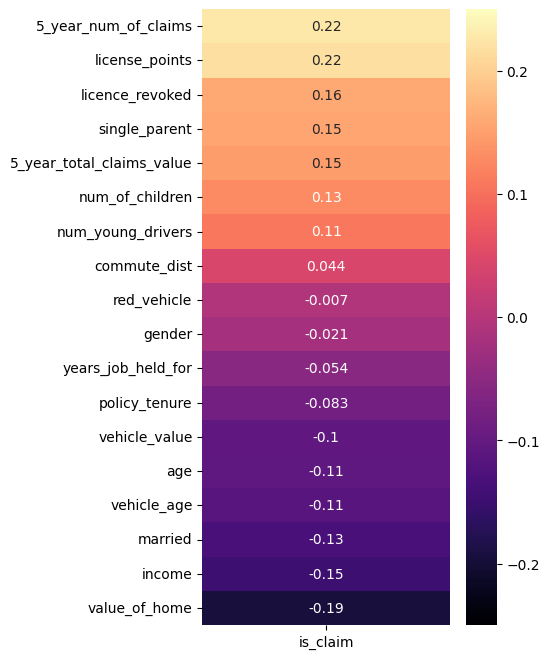

In [42]:
fig, ax = plt.subplots(figsize=(4, 8))

corr_matrix = eda_test_data.corr(numeric_only=True).sort_values(by='is_claim',ascending=False)
corr_matrix_no_claim = corr_matrix.drop('is_claim')

sns.heatmap(corr_matrix_no_claim[['is_claim']],cmap='magma', annot=True, vmax=0.25, vmin=-0.25)